In [75]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
matplotlib.rcParams.update({ 'font.size': 14 })

In [31]:
df = pd.read_csv('./basic_cnn_results.csv')
datasets = sorted(df.Train.unique())

In [41]:
grid = np.array([[
  df[(df.Train==d1)&(df.Test==d2)].MSE.values[0]
    for d2 in datasets]
    for d1 in datasets]) * 1e20

In [66]:
def label_for(ds):
  if 'single' in ds:
    s = f"80,000 steps * 1 run\n(restart {1+int('2' in ds)})"
  else:
    s = '80 steps * 1000 runs\n(sample '
    if 'uniform' in ds:
      s += 'every 1K)'
    else:
      s += 'irregularly)'
  return s

Text(0.5,1,'Basic CNN results on four $\\mathtt{pyqg}$ datasets\n(predicting $S_q$ from $q$, 64 to 32 res.)')

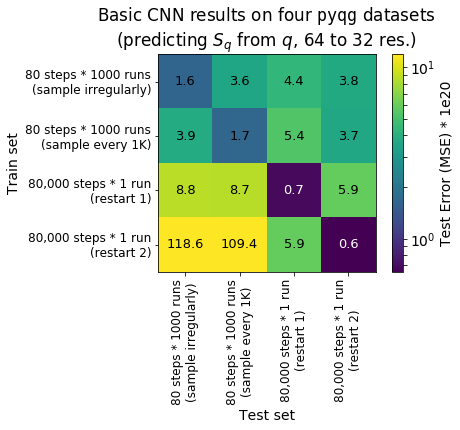

In [88]:
plt.imshow(grid, norm=colors.LogNorm(vmin=grid.min(), vmax=grid.max()/10))
for i, row in enumerate(grid):
  for j, val in enumerate(row):
    plt.text(j,i,f"{val:.1f}",ha='center',va='center',fontsize=13,color=('white' if val<1 else 'black'))
labels = list(map(label_for, datasets))
plt.xticks(range(len(datasets)), labels, rotation=90, fontsize=12)
plt.yticks(range(len(datasets)), labels, fontsize=12)
plt.ylabel("Train set")
plt.xlabel("Test set")
plt.colorbar(label='Test Error (MSE) * 1e20')
plt.title("Basic CNN results on four $\mathtt{pyqg}$ datasets\n(predicting $S_q$ from $q$, 64 to 32 res.)")